# Load full data 

In [27]:
import numpy as np
import pandas as pd
from scipy import special
from copy import copy
import math
import seaborn as sns
import importlib
import matplotlib.pyplot as plt
import warnings
from scipy.stats import norm
from tqdm import tqdm
warnings.filterwarnings("ignore")

In [28]:
import sklearn.linear_model as lm

In [29]:
df_full = pd.read_csv('/Users/harshparikh/IIC/step1_output/covariates-full.csv',index_col=0)

In [30]:
print(list(df_full.columns))

['Gender', 'Age', 'The start day of first EEG', 'Total EEG', 'Date of admission ', 'Date of discharge', 'marrital status  unmarried (if the pt was divorced or is widow is still in this category)=0 married=1', 'iGCS-Total', 'iGCS = T?     no=0 yes=1 ', 'iGCS-E', 'iGCS-V', 'iGCS-M', 'Worst GCS in 1st 24 ', 'Worst GCS Intubation status no=0 yes=1', 'APACHE II  first 24 ', 'temp/F', 'temp/F highest (first 24h)', 'temp/F lowest (first 24h)', 'temp/C', 'temp/C highest (first 24h)', 'temp/C lowest (first 24h)', 'MEAN Arterial p', 'Systo BP', ' SBP Highest (first 24h)', 'SBP Lowest (first 24h)', 'diastol BP', 'DBP Highest (first 24h)', 'DBP lowest (first 24h)', 'HR', 'HR highest (first 24h)', 'HR lowest (first 24h)', 'RR', 'RR highest (first 24h)', 'RR lowest (first 24h)', '1-cirrhosis of the liver confirmed By biopsy 2-new york heart association class IV 3-severe COPD hypercapnia, home O2 use or pulmonary HTN 4-on regular dialysis 5-immunocompromised', 'none=0                                 

In [31]:
github = '/Users/harshparikh/Documents/GitHub/iic_causal_inference'
file = '/aim1/step6_simulator/results_iic_burden_smooth/params_mean_CNNIIC_iic_burden_smooth_cauchy_expit_lognormal_drugoutside_ARMA2,6_iter1000.csv'
df_learned_params = pd.read_csv(github+file,index_col=0)

In [32]:
df_learned_params.head()

,IsIn977Pts,cluster,maxD,maxE,alpha0,alpha[1],alpha[2],theta[1],theta[2],theta[3],...,"premorbid MRS before admission (modified ranking scale),before admission","SZ at presentation,(exclude non-convulsive seizures) just if it is mentioned in MGH notes (the date is necessary, however,the date is the day of admission at MGH)",hydrocephalus (either on admission or during hospital course) QPID,iMV (initial (on admission) mechanical ventilation),Midline shift with any reason ( Document Date),Primary systemic dx Sepsis/Shock,iGCS-Total,neuro_dx_Seizures/status epilepticus,prim_dx_Respiratory disorders,mean arterial pressure
SID,,,,,,,,,,,,,,,,,,,,,
sid2,1,1,128.645486,1.000000,0.332172,0.497090,0.045100,0.099999,0.059804,-0.004869,...,1.0,0,1,0,1,0,7,0,1,106.666667
sid3,1,10,107.551461,1.000000,0.583871,0.493105,0.111527,0.099996,0.065089,-0.011720,...,5.0,0,0,1,0,0,8,0,1,112.000000
sid4,1,8,36.814206,1.000000,0.188013,0.155239,0.491172,0.099998,0.055131,0.003483,...,0.0,0,0,0,1,0,4,0,1,96.666667
sid5,1,11,20.451070,0.412371,-5.580504,-0.013525,-0.015951,0.099997,0.071171,0.005091,...,1.0,0,0,1,0,0,6,1,0,109.666667
sid6,0,4,0.000000,1.000000,0.293477,0.498598,-0.072789,0.099998,0.051973,-0.013975,...,1.0,1,0,0,0,0,14,1,0,98.666667


In [33]:
df_full['included'] = np.zeros((df_full.shape[0],))
df_full.loc[df_learned_params.index,'included'] = 1

<AxesSubplot:xlabel='included', ylabel='count'>

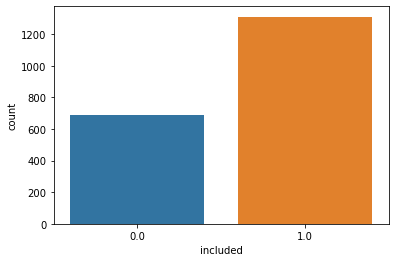

In [34]:
sns.countplot(df_full['included'])

In [40]:
df_full['temp/F highest (first 24h)']

Index
sid1        99.0
sid2        98.0
sid3       101.7
sid4        96.3
sid5       100.6
           ...  
sid1996     98.6
sid1997     98.4
sid1998     98.9
sid1999     99.7
sid2000     98.9
Name: temp/F highest (first 24h), Length: 1999, dtype: float64

In [90]:
df_cleaned = df_full[['Gender', 
#                       'Age',
                    'marrital status  unmarried (if the pt was divorced or is widow is still in this category)=0 married=1', 
#                     'Worst GCS in 1st 24 ', 
#                     'temp/F highest (first 24h)', 
                    'Hx CVA (including TIA)   no=0 yes=1', 'Hx HTN     no=0 yes=1', 'Hx Sz /epilepsy        no=0 yes=1',
                    'Hx brain surgery      no=0 yes=1', 'Hx CKD     no=0 yes=1', 'Hx CAD/MI      no=0 yes=1', 
                    'Hx CHF     no=0 yes=1', 'Hx DM      no=0 yes=1', 'Hx of HLD', 'Hx PUD', 'Hx liver failure     no=0 yes=1',
                    'Hx tobacco (including ex-smokers)   no=0  yes=1', 'Hx ETOH abuse any time in their life (just when in the hx is mentioned)    no=0 yes=1', 
                    'Hx cancer (other than CNS cancer)      no=0 yes=1', 'Hx CNS cancer     no=0 yes=1', 
                    'Hx PVD      no=0 yes=1', 'Hx dementia    no=0 yes=1', 
                    'Hx COPD/ Asthma    no=0 yes=1', 
                    'Hx leukemia/lymphoma     no=0 yes=1',
                    'Hx AIDs    no=0 yes=1', 'Hx CTD    no=0 yes=1',
                    'premorbid MRS before admission  (modified ranking scale),before admission',
                    'hydrocephalus  (either on admission or during hospital course)   QPID                 no=0, yes=1', 
                    'iMV  (initial (on admission) mechanical ventilation)   no=0, yes = 1',  
#                     'systolic BP', 'diastolic BP',
                    'EEGd1 MV  no=0, yes =1', 
#                     'EEGd1 GCS              actual score', 
#                     '        EEGd1 Map  (mean arterial pressure)  ', 
#                     'EEGd1 syst BP( Closest to the date of EEG)', 
#                     'diast BP, if not available: NA', 
                    'EEGde MV  no=0, yes =1', 
                    'EEGde GCS             actual scores', 
                    'DC MRS (modified ranking scale)', 
#                     'reason COMFORT ONLY (CMO) /W-LST reason   no CMO=0          primary neuro reason=1      non-neuro reason=2', 
#                     ' SDH age None 0         acute=4   subacute=1           chronic=2           acute on chronic=3', 
#                     'CNS tumor location None 0     Frontal=5    parietal=1    temporal=2   occipital=3     post. Fossa=4   intraventricular=5',
                    'neurosx procedures    DC summary, op notes or neurosurgery notes    No=0        YES=1', 
                    'Other HAI                 No=0         yes=1', 
                    'HAI-PNA               No=0           yes=1', 
                    'HAI-UTI                No=0     yes=1',
                    'HAI-Sepsis/SEPTICEMIA          No=0      Yes=1', 
                    'HAI-meningitis/ventriculitis/cerebritis              No=0      Yes=1', 
                    'HAI-Cdiff              No=0    Yes=1', 
                    'DVT                      No=0         Yes=1','included']].replace(to_replace = 'na', value = 0 ).dropna()
df_cleaned['Gender'] = (df_cleaned['Gender'] == 'M').astype(int)

In [91]:
df_cleaned.to_csv('full_cov_cleaned.csv')

In [92]:
discriminator = lm.RidgeClassifierCV().fit(df_cleaned.drop(columns=['included']),df_cleaned['included'])

In [93]:
discriminator.score(df_cleaned.drop(columns=['included']),df_cleaned['included'])

0.6898535564853556

In [96]:
pd.DataFrame(discriminator.coef_,columns=df_cleaned.drop(columns=['included']).columns).T.sort_values(by=0)

,0
Hx CHF no=0 yes=1,-0.222352
Hx PUD,-0.138087
Hx liver failure no=0 yes=1,-0.117441
Hx PVD no=0 yes=1,-0.107735
Hx CAD/MI no=0 yes=1,-0.099634
Gender,-0.087934
HAI-Sepsis/SEPTICEMIA No=0 Yes=1,-0.080821
Hx CTD no=0 yes=1,-0.076374
Hx cancer (other than CNS cancer) no=0 yes=1,-0.074709
Hx tobacco (including ex-smokers) no=0 yes=1,-0.053258


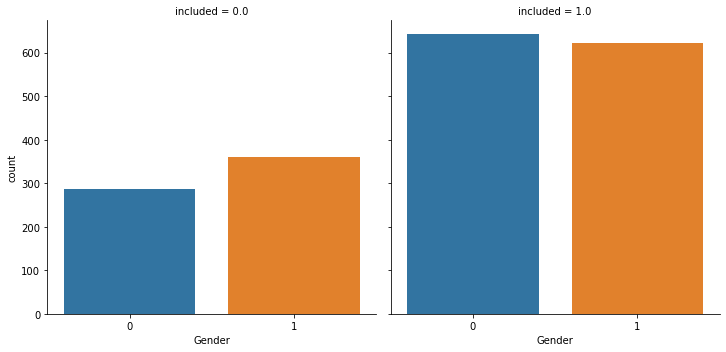

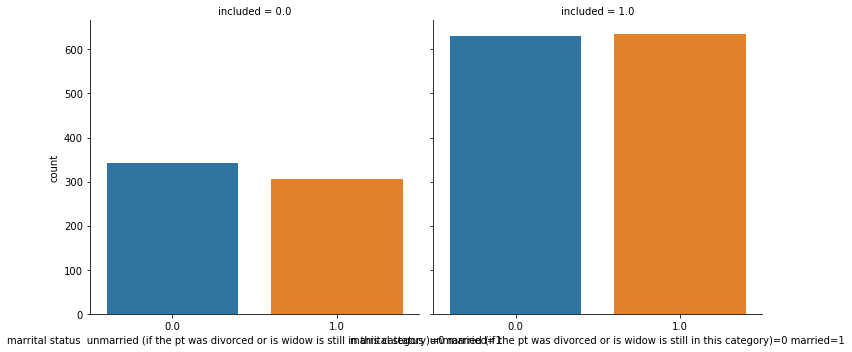

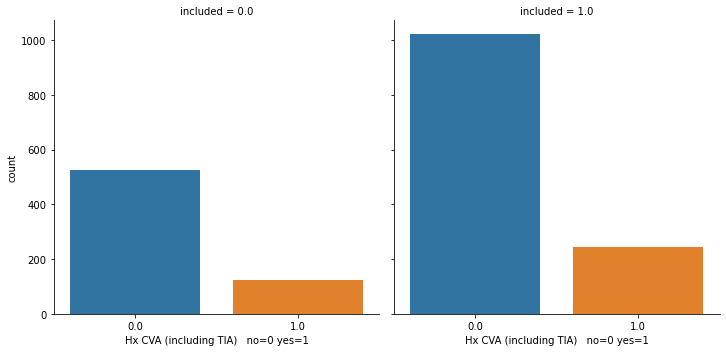

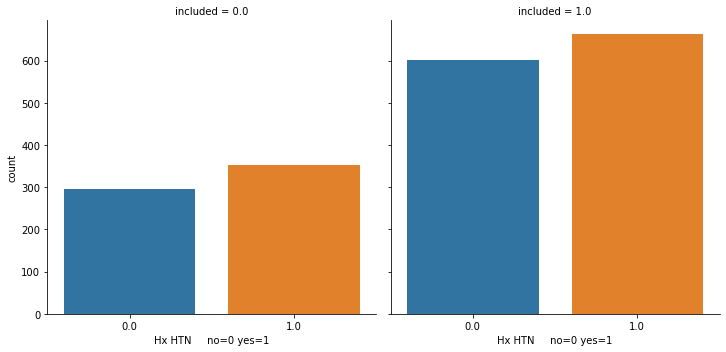

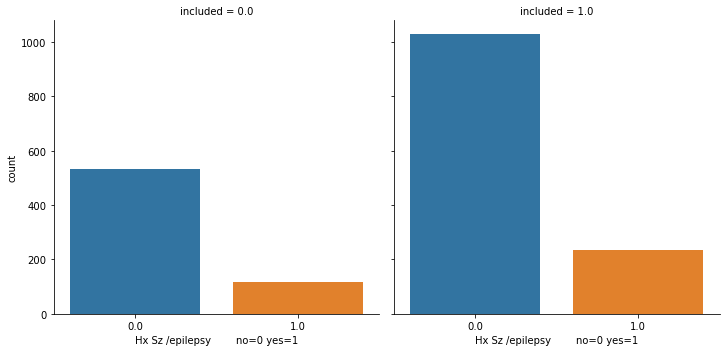

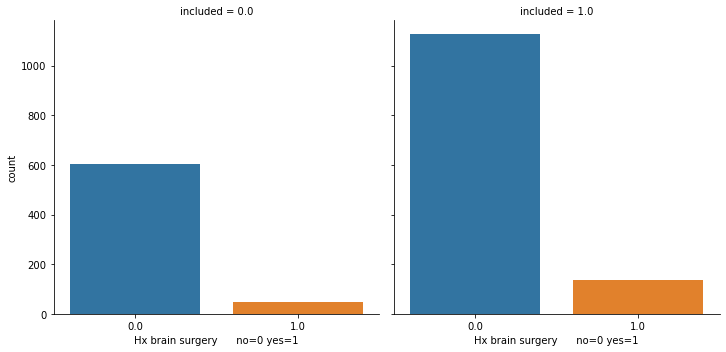

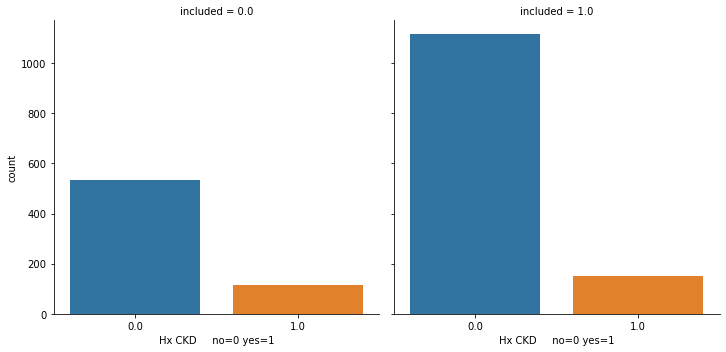

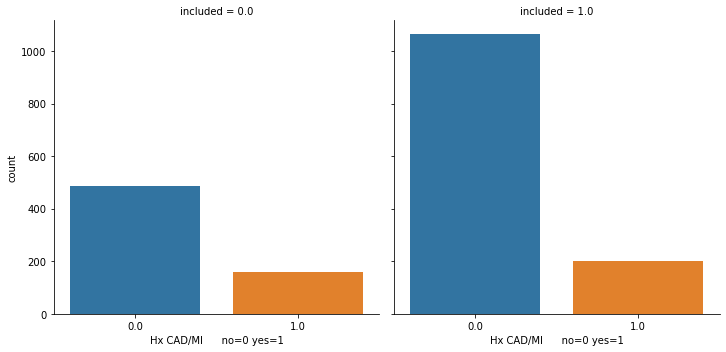

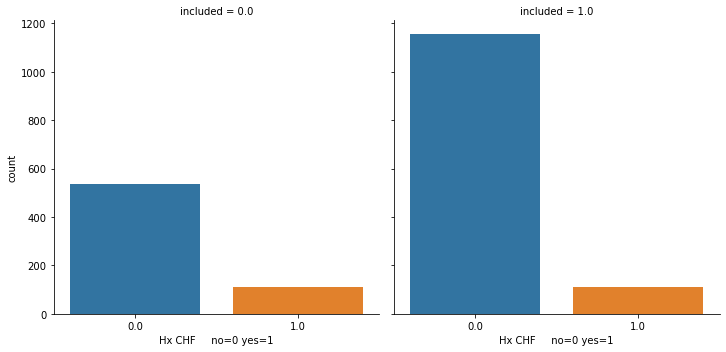

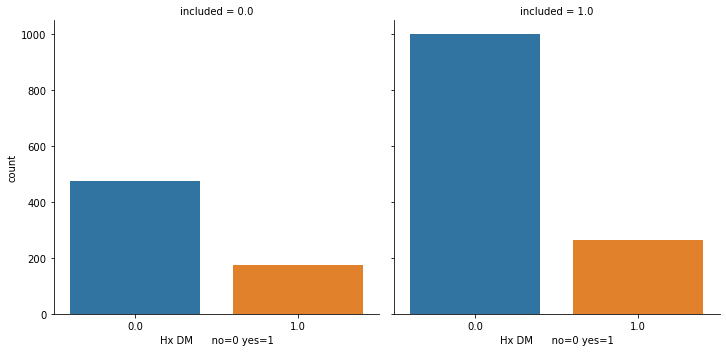

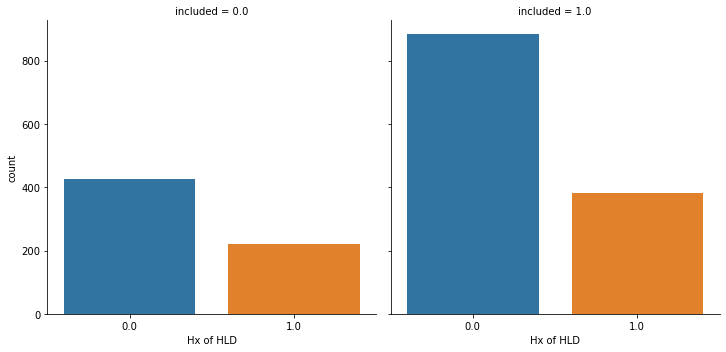

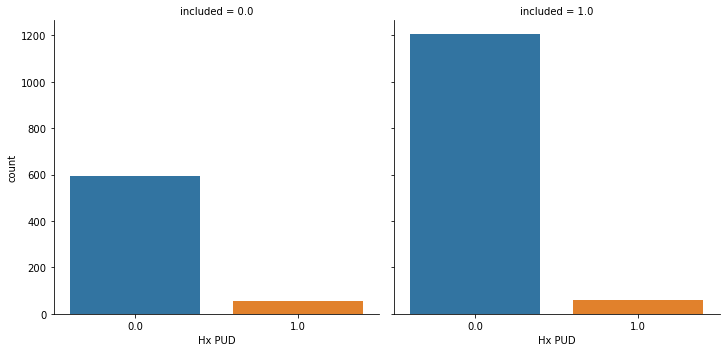

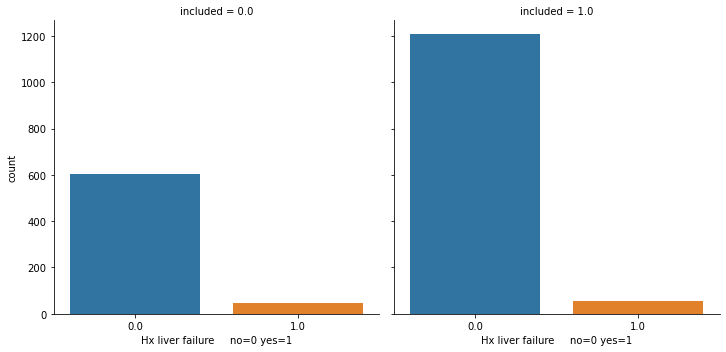

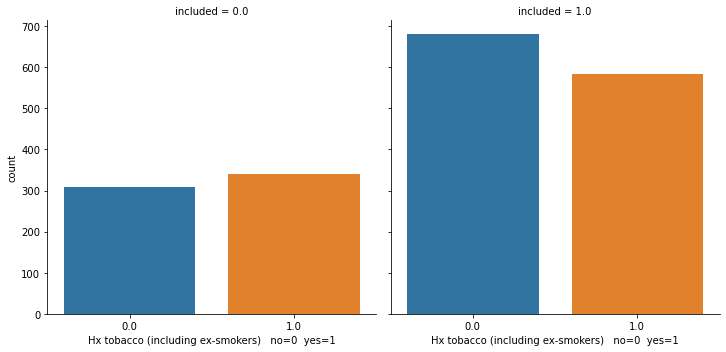

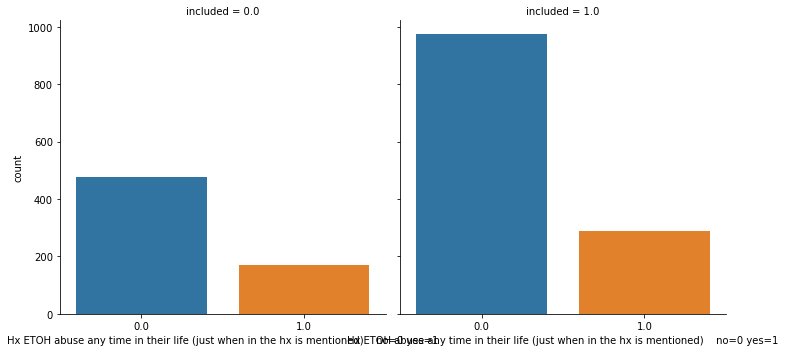

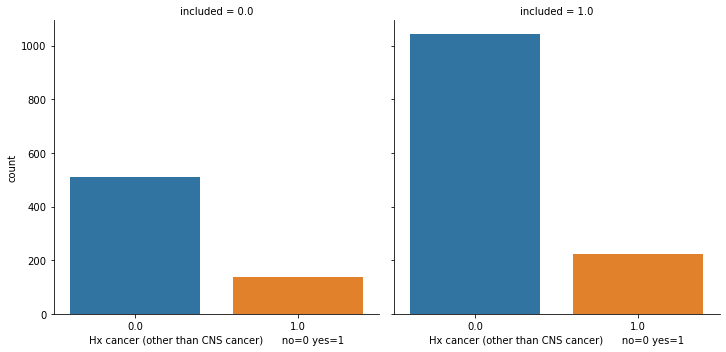

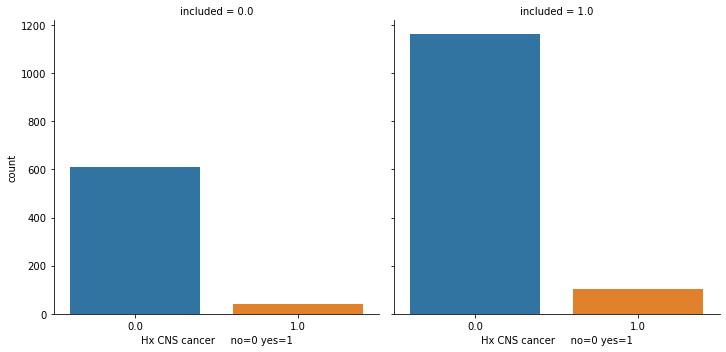

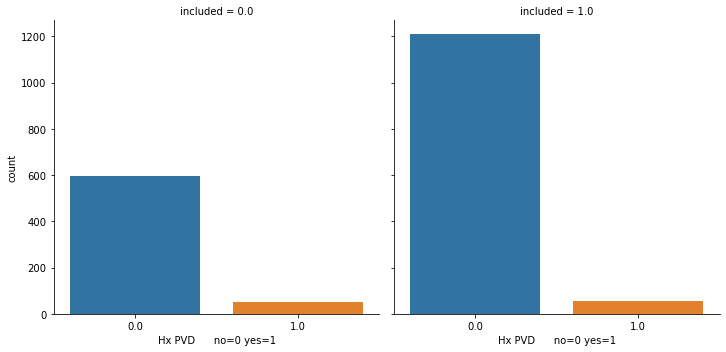

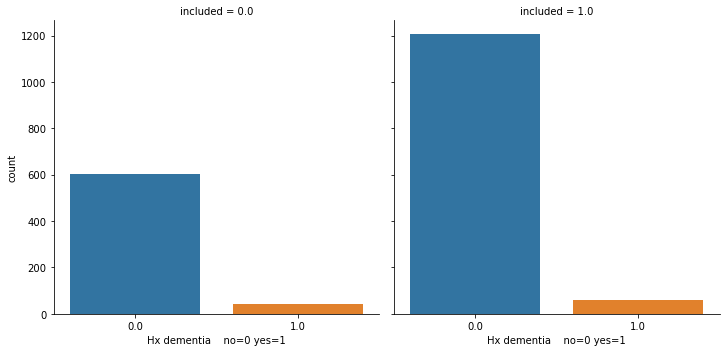

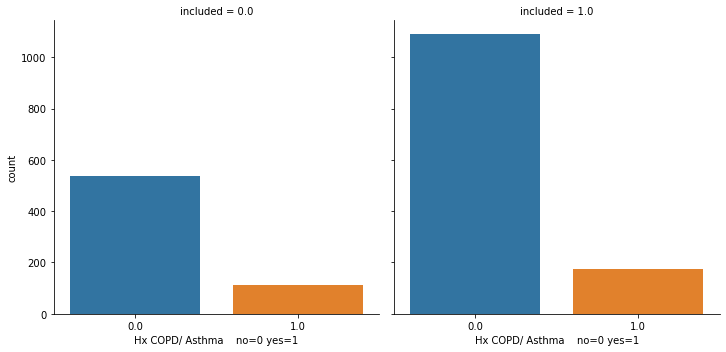

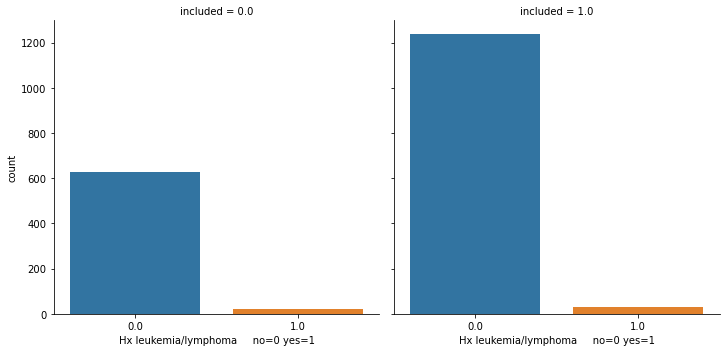

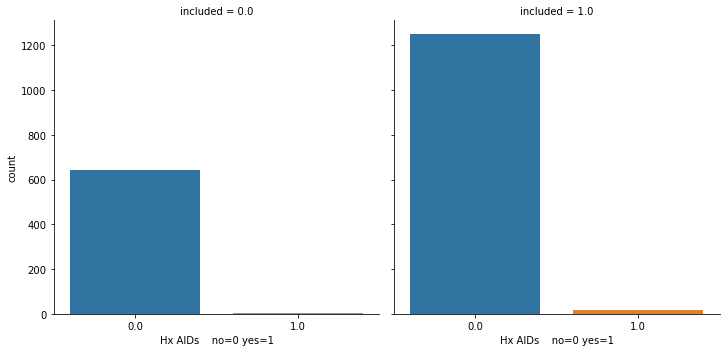

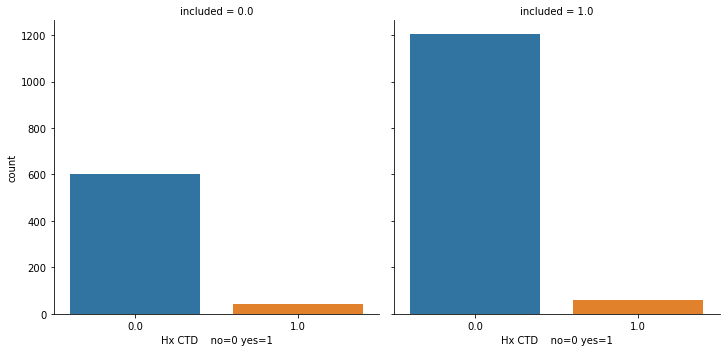

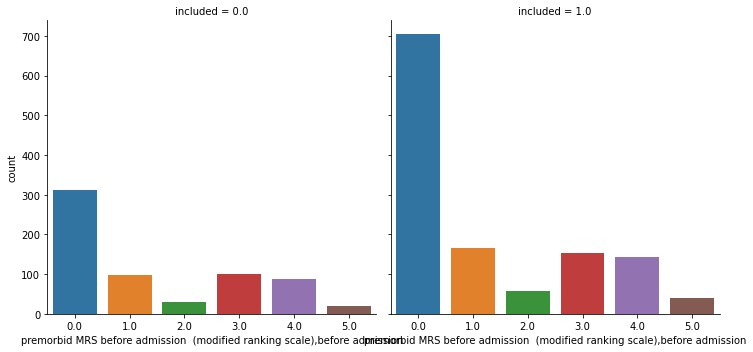

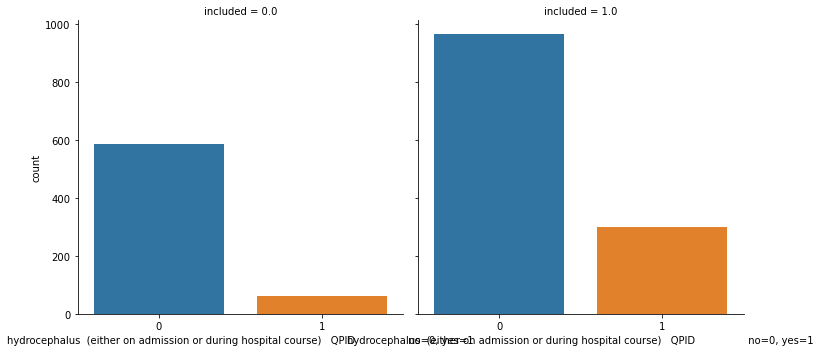

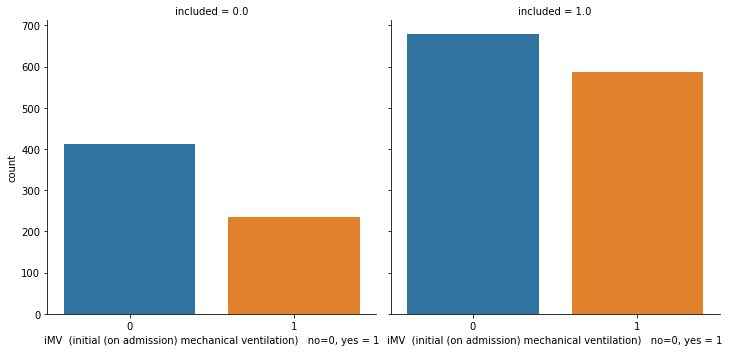

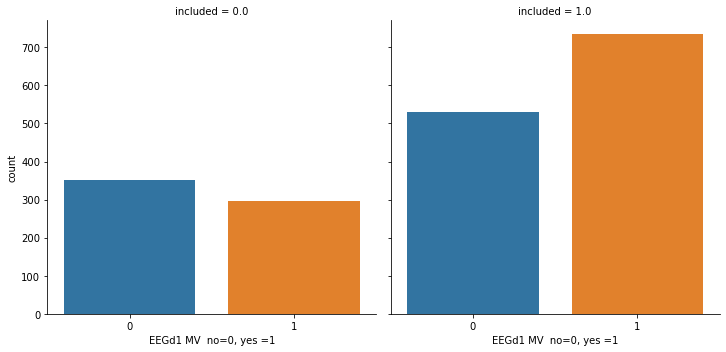

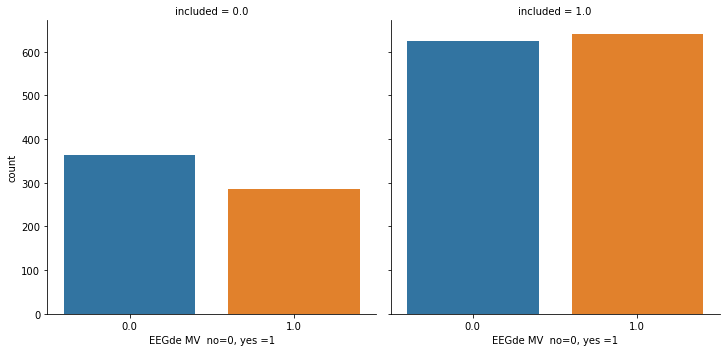

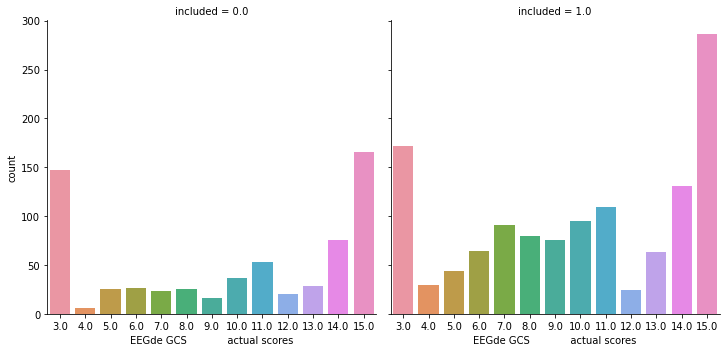

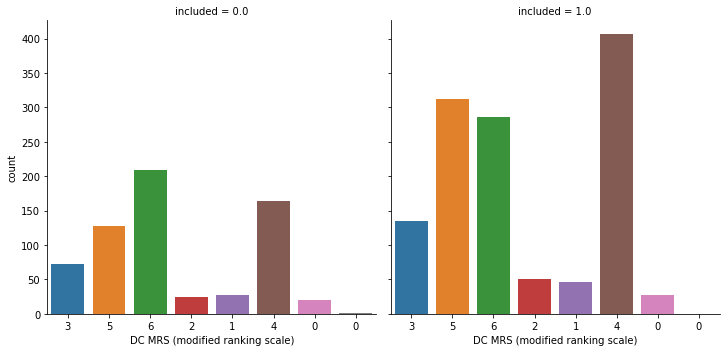

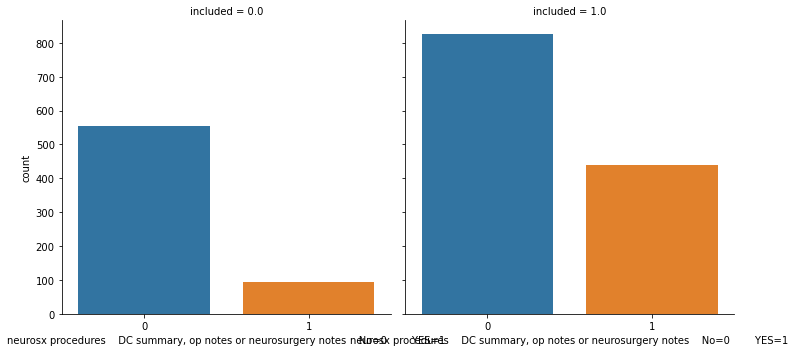

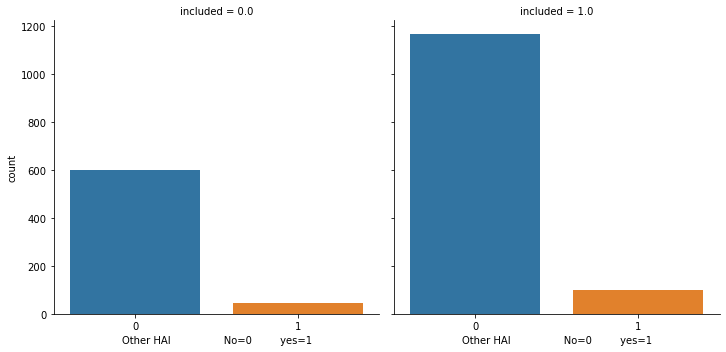

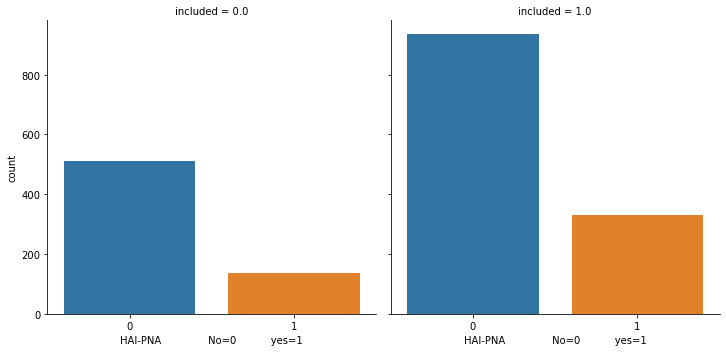

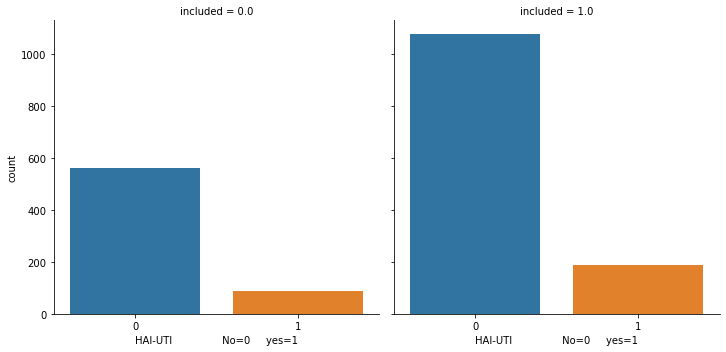

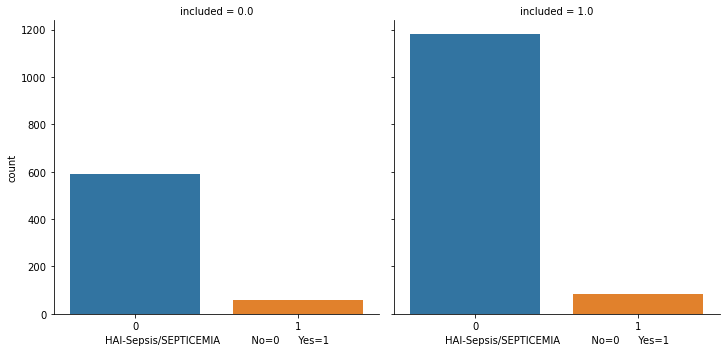

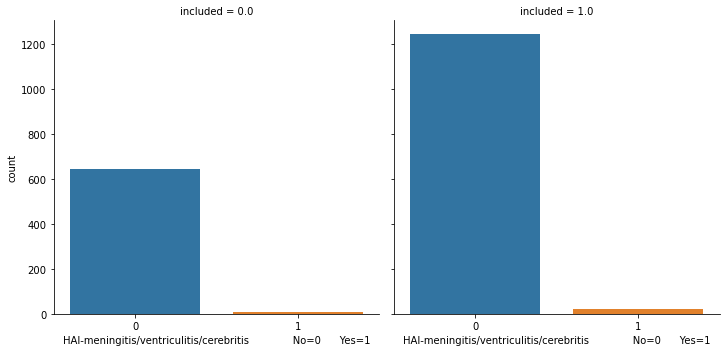

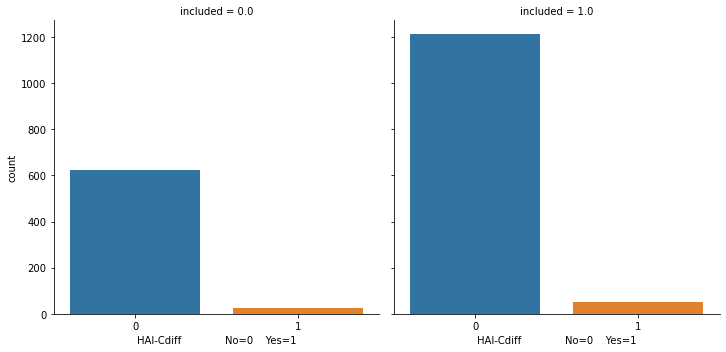

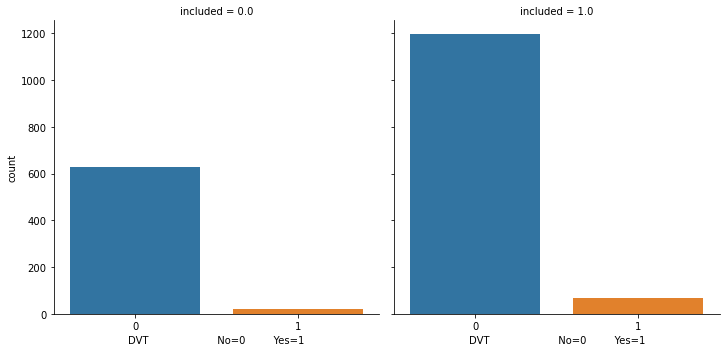

In [98]:
for i in range(len(df_cleaned.drop(columns=['included']).columns)):
    col_name = df_cleaned.drop(columns=['included']).columns[i]
    sns.catplot(col='included',x=col_name,data=df_cleaned,kind='count')

In [99]:
print(list(df_learned_params.columns))

['IsIn977Pts', 'cluster', 'maxD', 'maxE', 'alpha0', 'alpha[1]', 'alpha[2]', 'theta[1]', 'theta[2]', 'theta[3]', 'theta[4]', 'theta[5]', 'theta[6]', 'sigma_err', 'b[lacosamide]', 'b[levetiracetam]', 'b[midazolam]', 'b[pentobarbital]', 'b[phenobarbital]', 'b[propofol]', 'b[valproate]', 'Gender', 'Age', 'marrital', 'Hx CVA (including TIA)', 'Hx HTN', 'Hx Sz /epilepsy', 'Hx brain surgery', 'Hx CKD', 'Hx CAD/MI', 'Hx CHF', 'Hx DM', 'Hx of HLD', 'Hx tobacco (including ex-smokers)', 'Hx ETOH abuse any time in their life (just when in the hx is mentioned)', 'Hx other substance abuse, any time in their life', 'Hx cancer (other than CNS cancer)', 'Hx CNS cancer', 'Hx COPD/ Asthma', 'premorbid MRS before admission  (modified ranking scale),before admission', 'SZ at presentation,(exclude non-convulsive seizures) just if it is mentioned in MGH notes (the date is necessary, however,the date is the day of admission at MGH)', 'hydrocephalus  (either on admission or during hospital course)   QPID', 'iM

<AxesSubplot:xlabel='maxD'>

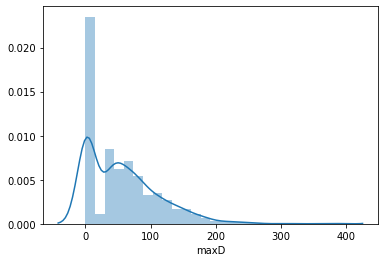

In [130]:
sns.distplot(df_learned_params['maxD'])

<AxesSubplot:xlabel='maxD', ylabel='count'>

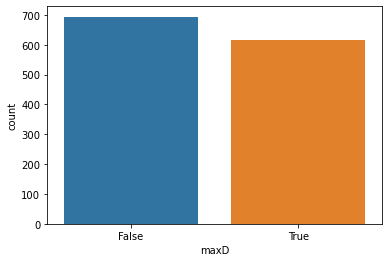

In [132]:

sns.countplot(df_learned_params['maxD']>50)

In [133]:
df_analysis = df_learned_params[[ 'alpha0', 'alpha[1]', 'alpha[2]', 'theta[1]', 'theta[2]', 'theta[3]', 'theta[4]', 'theta[5]', 'theta[6]', 'sigma_err', 'b[lacosamide]', 'b[levetiracetam]', 'b[midazolam]', 'b[pentobarbital]', 'b[phenobarbital]', 'b[propofol]', 'b[valproate]']]
df_analysis['T'] = (df_learned_params['maxD']>50).astype(int)
df_analysis['Y'] = (((df_cleaned.loc[df_analysis.index]['DC MRS (modified ranking scale)']).astype(float))>3).astype(int)
df_analysis.fillna(0,inplace=True)

In [134]:
df_analysis

,alpha0,alpha[1],alpha[2],theta[1],theta[2],theta[3],theta[4],theta[5],theta[6],sigma_err,b[lacosamide],b[levetiracetam],b[midazolam],b[pentobarbital],b[phenobarbital],b[propofol],b[valproate],T,Y
SID,,,,,,,,,,,,,,,,,,,
sid2,0.332172,0.497090,0.045100,0.099999,0.059804,-0.004869,0.006779,-0.004244,-0.002888,4.395345,0.00000,0.008682,0.0,0.0,0.0,0.000000,0.0,1,1
sid3,0.583871,0.493105,0.111527,0.099996,0.065089,-0.011720,-0.021534,-0.007574,-0.003565,3.677750,0.00000,0.966040,0.0,0.0,0.0,0.000000,0.0,1,1
sid4,0.188013,0.155239,0.491172,0.099998,0.055131,0.003483,0.002468,0.002882,-0.001086,2.401246,0.00000,0.010657,0.0,0.0,0.0,0.039377,0.0,0,1
sid5,-5.580504,-0.013525,-0.015951,0.099997,0.071171,0.005091,-0.009600,0.000158,-0.002391,2.232872,6.58228,0.000000,0.0,0.0,0.0,2.554616,0.0,0,0
sid6,0.293477,0.498598,-0.072789,0.099998,0.051973,-0.013975,-0.007934,0.005542,0.005023,4.019510,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sid1989,-1.004246,0.274695,0.074744,0.099999,0.058657,-0.015196,-0.007653,-0.007279,-0.004513,3.980773,0.00000,0.022612,0.0,0.0,0.0,0.000000,0.0,1,0
sid1990,0.073480,-0.050963,0.434934,0.099998,0.051973,-0.013975,-0.007934,0.005542,0.005023,4.019510,0.00000,0.009184,0.0,0.0,0.0,0.000000,0.0,1,0
sid1991,-0.027244,0.103983,0.479641,0.099999,0.064920,-0.007573,-0.003327,0.005538,-0.000129,4.059736,0.00000,0.005043,0.0,0.0,0.0,0.044960,0.0,1,1


In [135]:
import pymalts as pm

In [136]:
m = pm.malts_mf(outcome='Y',treatment='T',data=df_analysis.drop(columns=['sigma_err']))

In [137]:
m.CATE_df

,avg.CATE,std.CATE,Y,T
sid100,0.015746,0.126241,1.0,1.0
sid1001,0.003011,0.137328,0.0,0.0
sid1002,0.083262,0.141714,1.0,1.0
sid1007,0.058188,0.117083,1.0,0.0
sid1012,0.018462,0.200274,0.0,1.0
...,...,...,...,...
sid987,-0.007324,0.131292,0.0,1.0
sid988,0.009359,0.145838,1.0,1.0
sid99,-0.011487,0.141045,1.0,1.0
sid994,0.101685,0.132527,0.0,1.0


In [138]:
m.CATE_df['avg.CATE'].mean()

0.05650738455366113

<AxesSubplot:xlabel='alpha0'>

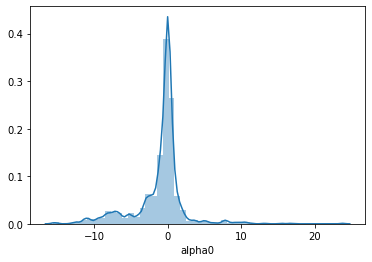

In [139]:
sns.distplot(df_analysis['alpha0'])